<a href="https://colab.research.google.com/github/misko/spf/blob/main/03_beamformer_wNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

'''

Given some guess of the source of direction we can shift the carrier frequency
phase of received samples at the N different receivers. If the guess of the
source direction is correct, the signal from the N different receivers should
interfer constructively.

'''

c=3e8 # speed of light

class Source(object):
  def __init__(self,pos):
    self.pos=np.array(pos)

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times)+np.sin(2*np.pi*sampling_times)*1j

  def demod_signal(self,signal,demod_times):
    return signal

class SinSource(Source):
  def __init__(self,pos,frequency,phase):
    super().__init__(pos)
    self.frequency=frequency
    self.phase=phase

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times*self.frequency+self.phase)+np.sin(2*np.pi*sampling_times*self.frequency+self.phase)*1j

class MixedSource(Source):
  def __init__(self,source_a,source_b):
    super().__init__(pos)
    self.source_a=source_a
    self.source_b=source_b

  def signal(self,sampling_times):
    return self.source_a(sampling_times)*self.source_b(sampling_times)

class QAMSource(Source):
  def __init__(self,pos,carrier_frequency,signal_frequency,sigma=0):
    super().__init__(pos)
    self.lo_in_phase=SinSource(pos,carrier_frequency,-np.pi/2) # cos
    self.lo_out_of_phase=SinSource(pos,carrier_frequency,0) # cos
    self.signal_source=SinSource(pos,signal_frequency,0)
    self.sigma=sigma

  def signal(self,sampling_times):
    signal=self.signal_source.signal(sampling_times)
    return ((self.lo_in_phase.signal(sampling_times)*signal.real+\
              self.lo_out_of_phase.signal(sampling_times)*signal.imag)/2) +\
                np.random.randn(sampling_times.shape[0])*self.sigma

  def demod_signal(self,signal,demod_times):
    return (self.lo_in_phase(demod_times)+\
              self.lo_out_of_phase(demod_times)*1j)*signal
  

class NoiseWrapper(Source):
  def __init__(self,internal_source,sigma=1):
    super().__init__(internal_source.pos)
    self.internal_source=internal_source
    self.sigma=sigma

  def signal(self,sampling_times):
    return self.internal_source.signal(sampling_times) + (np.random.randn(sampling_times.shape[0], 2)*self.sigma).view(np.cdouble).reshape(-1)

class Receiver:
  def __init__(self,pos):
    self.pos=np.array(pos)

class Detector(object):
  def __init__(self,sampling_frequency):
    self.sources=[]
    self.receivers=[]
    self.sampling_frequency=sampling_frequency

  def add_source(self,source):
    self.sources.append(source)

  def rm_sources(self):
    self.sources=[]

  def add_receiver(self,receiver):
    self.receivers.append(receiver)

  def get_signal_matrix(self,start_time,duration,rx_lo=0):
    n_samples=int(duration*self.sampling_frequency)
    base_times=start_time+np.linspace(0,n_samples-1,n_samples)/self.sampling_frequency
    sample_matrix=np.zeros((len(self.receivers),n_samples),dtype=np.cdouble) # receivers x samples
    for receiver_index,receiver in enumerate(self.receivers):
      for _source in self.sources:
        time_delay=np.linalg.norm(receiver.pos-_source.pos)/c
        sample_matrix[receiver_index,:]+=_source.demod_signal(_source.signal(base_times-time_delay),
                                                              base_times)
        if rx_lo>0:
          sample_matrix[receiver_index,:]
    return sample_matrix

  

In [2]:
def beamformer(detector,signal_matrix,carrier_frequency,calibration=None,spacing=64+1):
    if calibration is None:
        calibration=np.ones(len(detector.receivers)).astype(np.cdouble)
    thetas=np.linspace(-np.pi,np.pi,spacing)
    steer_dot_signal=np.zeros(thetas.shape[0])
    carrier_wavelength=c/carrier_frequency
    steering_vectors=np.zeros((len(thetas),len(detector.receivers))).astype(np.cdouble)
    for theta_index,theta in enumerate(thetas):
        source_vector=np.array([np.cos(theta),np.sin(theta)])
        projections=[]
        for receiver_index,receiver in enumerate(detector.receivers):
            projection_of_receiver_onto_source_direction=np.dot(source_vector,receiver.pos)
            projections.append(projection_of_receiver_onto_source_direction/carrier_wavelength)
            arg=2*np.pi*projection_of_receiver_onto_source_direction/carrier_wavelength
            steering_vectors[theta_index][receiver_index]=np.exp(-1j*arg)
        steer_dot_signal[theta_index]=np.absolute(np.matmul(steering_vectors[theta_index]*calibration,signal_matrix)).mean()
    return thetas,steer_dot_signal,steering_vectors
  

In [ ]:
def plot_space(ax,d,wavelength=1):
  #fig,ax=plt.subplots(1,1,figsize=(4,4))
  receiver_pos=np.vstack(
      [ receiver.pos/wavelength for receiver in d.receivers ]
                )
  _max=receiver_pos.max()
  _min=receiver_pos.min()
  buffer=(_max-_min)*0.1
  _max+=buffer
  _min-=buffer

  center_mass=receiver_pos.mean(axis=0)

  source_vectors=[ (source.pos/wavelength-center_mass)/np.linalg.norm(source.pos/wavelength-center_mass) for source in d.sources ]

  ax.set_xlim([_min,_max])
  ax.set_ylim([_min,_max])

  ax.scatter(receiver_pos[:,0],receiver_pos[:,1],label="Receivers")
  thetas=[]
  for source_vector in source_vectors:
    ax.quiver(center_mass[0], center_mass[1], 
              -source_vector[0], -source_vector[1], scale=5, alpha=0.5,color='red',label="Source")
    thetas.append( 360*np.arctan2(source_vector[1],source_vector[0])/(2*np.pi) )

  ax.legend()
  ax.set_xlabel("x (wavelengths)")
  ax.set_ylabel("y (wavelengths)")
  ax.set_title("Space diagram (%s)" % ",".join(map(lambda x : "%0.2f" % x ,thetas)))


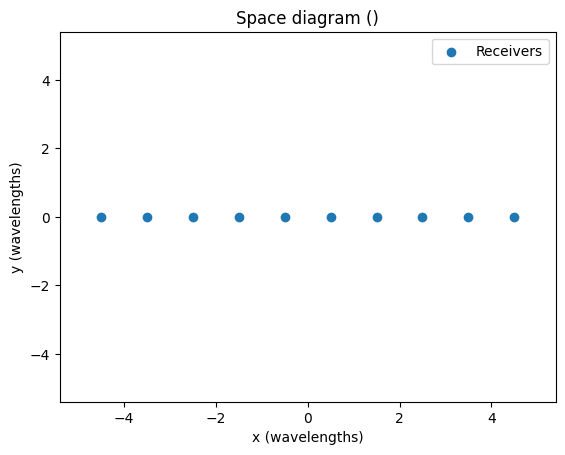

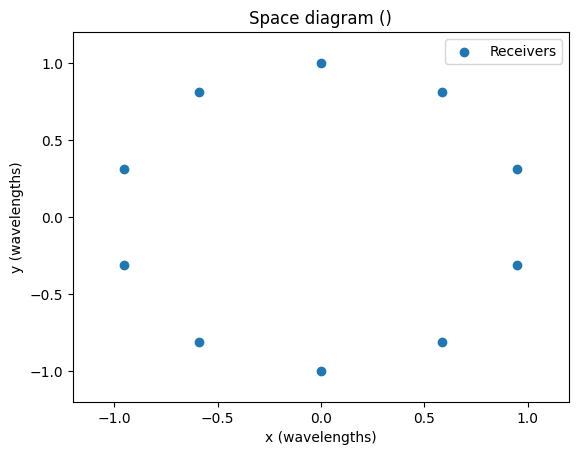

In [ ]:
class ULADetector(Detector):
  def __init__(self,sampling_frequency,n_elements,spacing):
    super().__init__(sampling_frequency)
    for idx in np.arange(n_elements):
      self.add_receiver(Receiver([
          spacing*(idx-(n_elements-1)/2),
          0]))
ula_d=ULADetector(300,10,1)
fig,ax=plt.subplots(1,1)
plot_space(ax,ula_d)
      
class UCADetector(Detector):
  def __init__(self,sampling_frequency,n_elements,radius):
    super().__init__(sampling_frequency)
    for theta in np.linspace(0,2*np.pi,n_elements+1)[:-1]+np.pi/2: # orientate along y axis
      self.add_receiver(Receiver([
          radius*np.cos(theta),
          radius*np.sin(theta)]))
uca_d=UCADetector(300,10,1)
fig,ax=plt.subplots(1,1)
plot_space(ax,uca_d)

In [ ]:

def analyze_beamformer(d,carrier_frequency,signal_frequency,sigma=1,
                       n_repeats=5,n_intervals=18,plot_raw_signal=False,n=10):
  
  n_receivers=len(d.receivers)
  fig,axs=plt.subplots(n_intervals,n_receivers*plot_raw_signal+2,figsize=(4*(n_receivers*plot_raw_signal+2),4*n_intervals))
  
  wavelength=c/carrier_frequency
  for theta_idx,theta in enumerate(np.linspace(-np.pi,np.pi,n_intervals)):
    d.rm_sources()
    d.add_source(NoiseWrapper(
          QAMSource([
          wavelength*100000*np.cos(theta),
          wavelength*100000*np.sin(theta)],
          carrier_frequency,signal_frequency,sigma=sigma),sigma=sigma))

    signal_matrix=d.get_signal_matrix(0,n/d.sampling_frequency) 
    n_samples=signal_matrix.shape[1]

    if plot_raw_signal:
      #plot raw signal so we get an idea of whats going in
      for idx in range(signal_matrix.shape[0]):
        axs[theta_idx][idx+2].scatter(np.arange(n_samples),
                                    signal_matrix[idx].real+signal_matrix[idx].imag,label='baseband',alpha=1.0,s=0.7)
        axs[theta_idx][idx+2].legend()
        axs[theta_idx][idx+2].set_title("Receiver %d" % idx)
        axs[theta_idx][idx+2].set_xlabel("Sample")

    #lets do a few iterations to get an idea of how much variation there is

    beam_sds_repeats=[]
    for _ in range(n_repeats):
      signal_matrix=d.get_signal_matrix(0,n/d.sampling_frequency) 
      beam_thetas,beam_sds,steering_vectors=beamformer(d,signal_matrix,carrier_frequency)
      beam_sds/=beam_sds.sum() # normalize the response?
      beam_sds_repeats.append(beam_sds)
    beam_sds=np.vstack(beam_sds_repeats)
    
    beam_degrees=360*beam_thetas/(np.pi*2)
    axs[theta_idx][0].fill_between(beam_degrees,
                                            beam_sds.mean(axis=0)+beam_sds.std(axis=0),
                                            beam_sds.mean(axis=0)-beam_sds.std(axis=0),
                                            alpha=0.5)
    
    axs[theta_idx][0].plot(beam_degrees,beam_sds.mean(axis=0),alpha=0.5)
    axs[theta_idx][0].scatter(beam_degrees,beam_sds.mean(axis=0),s=0.5)
    axs[theta_idx][0].axvline(x=360*theta/(2*np.pi),label="Truth",color='red')
    axs[theta_idx][0].set_title("Response")
    axs[theta_idx][0].set_xlabel("Theta")
    axs[theta_idx][0].legend()

    plot_space(axs[theta_idx][1],d,wavelength)
  fig.tight_layout()

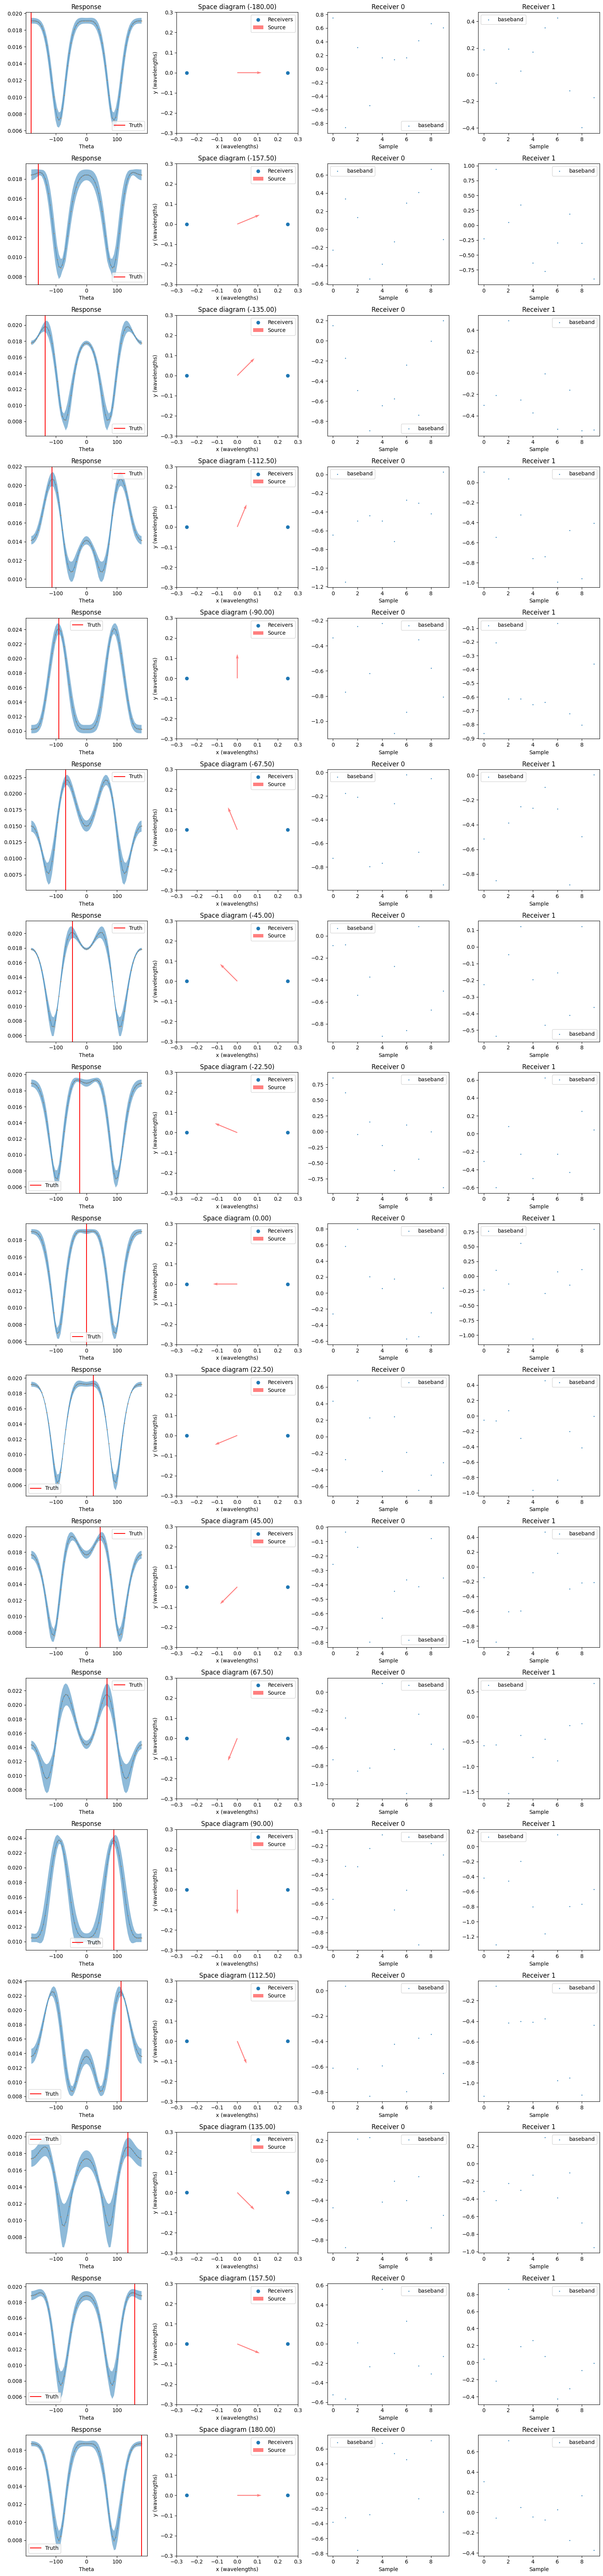

In [ ]:
carrier_frequency=2.4e9
signal_frequency=100e3 # 10khz signal 
wavelength=c/carrier_frequency
d=ULADetector(10e6,2,wavelength/2) # 10Mhz sampling

analyze_beamformer(d,carrier_frequency,signal_frequency,n_intervals=1+8*2, n_repeats=5, sigma=0.2,plot_raw_signal=True)

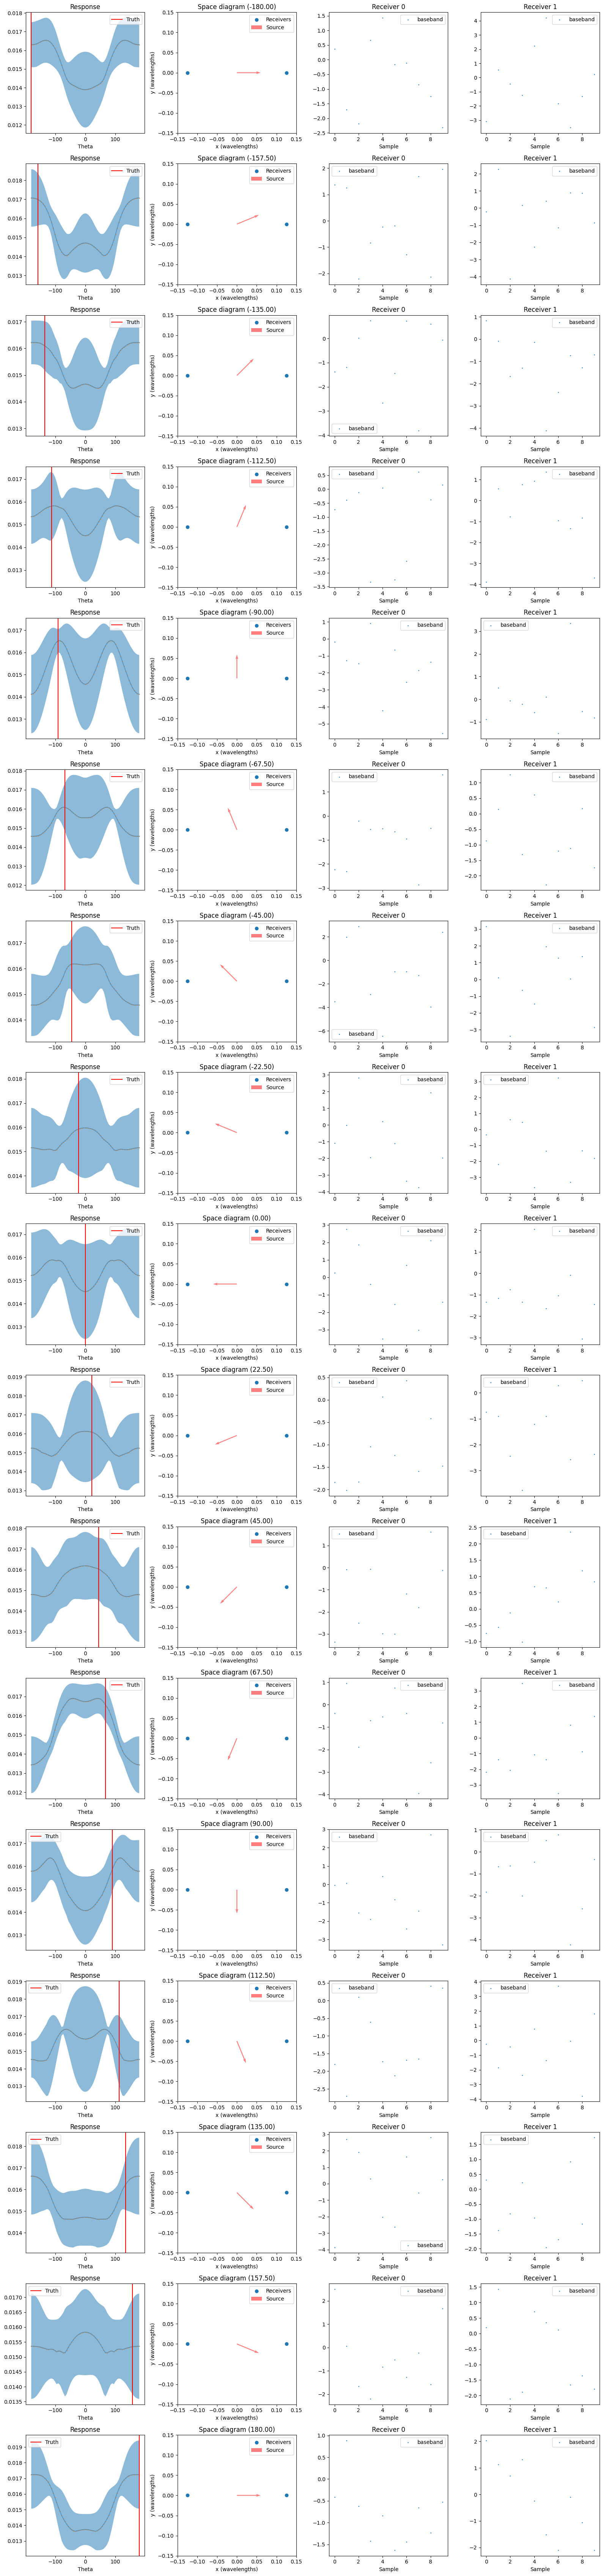

In [ ]:
carrier_frequency=2.4e9
signal_frequency=100e3 # 10khz signal 
wavelength=c/carrier_frequency
d=ULADetector(10e6,2,wavelength/4) # 10Mhz sampling

analyze_beamformer(d,carrier_frequency,signal_frequency,n_intervals=1+8*2, n_repeats=5, sigma=1,plot_raw_signal=True)

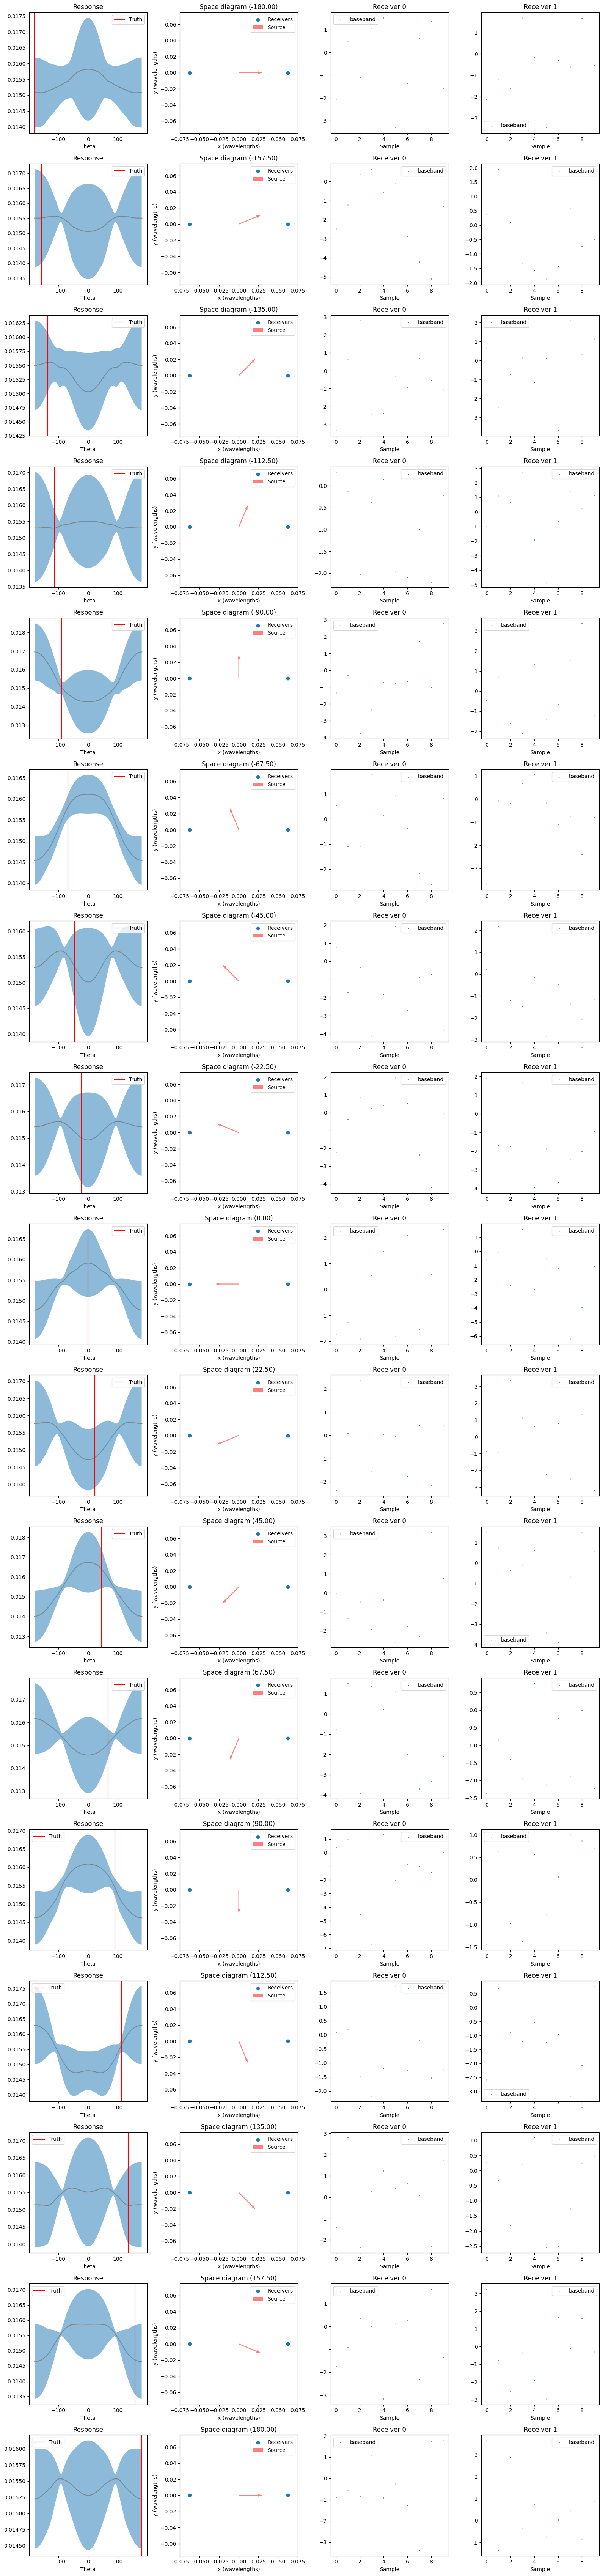

In [ ]:
carrier_frequency=2.4e9
signal_frequency=100e3 # 10khz signal 
wavelength=c/carrier_frequency
d=ULADetector(10e6,2,wavelength/8) # 1Mhz sampling

analyze_beamformer(d,carrier_frequency,signal_frequency,n_intervals=1+8*2, n_repeats=5, sigma=1,plot_raw_signal=True)

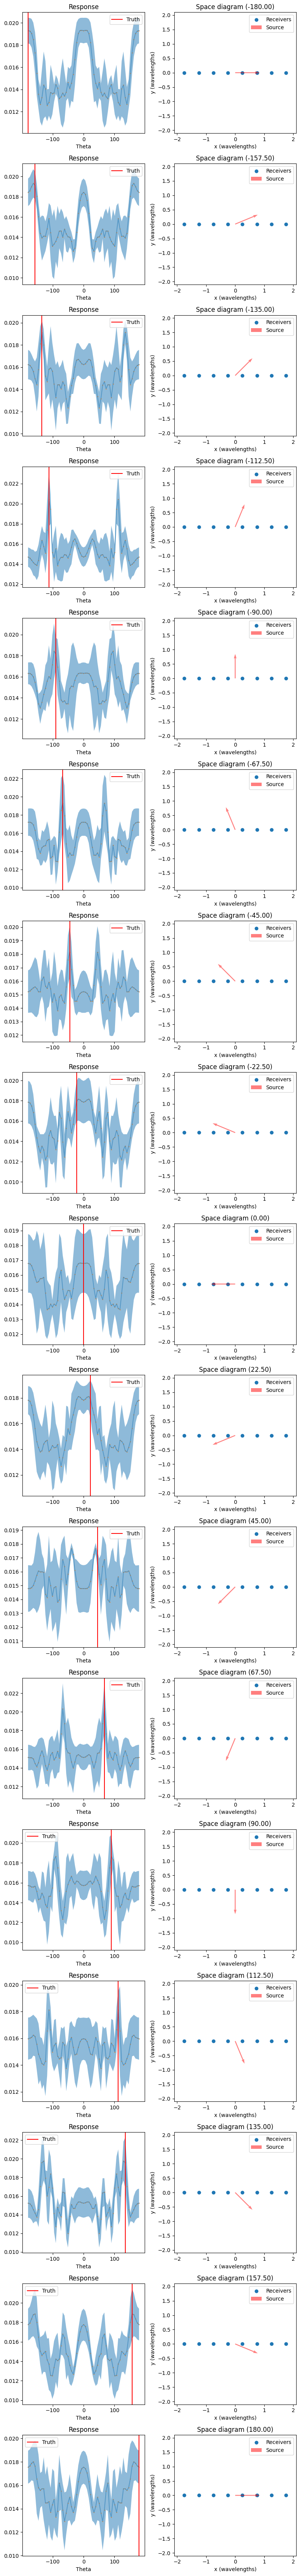

In [ ]:
carrier_frequency=2.4e9
signal_frequency=100e3 # 10khz signal 
wavelength=c/carrier_frequency
d=ULADetector(10e6,8,wavelength/2) # 1Mhz sampling

analyze_beamformer(d,carrier_frequency,signal_frequency,n_intervals=1+8*2, n_repeats=5, sigma=1,plot_raw_signal=False)

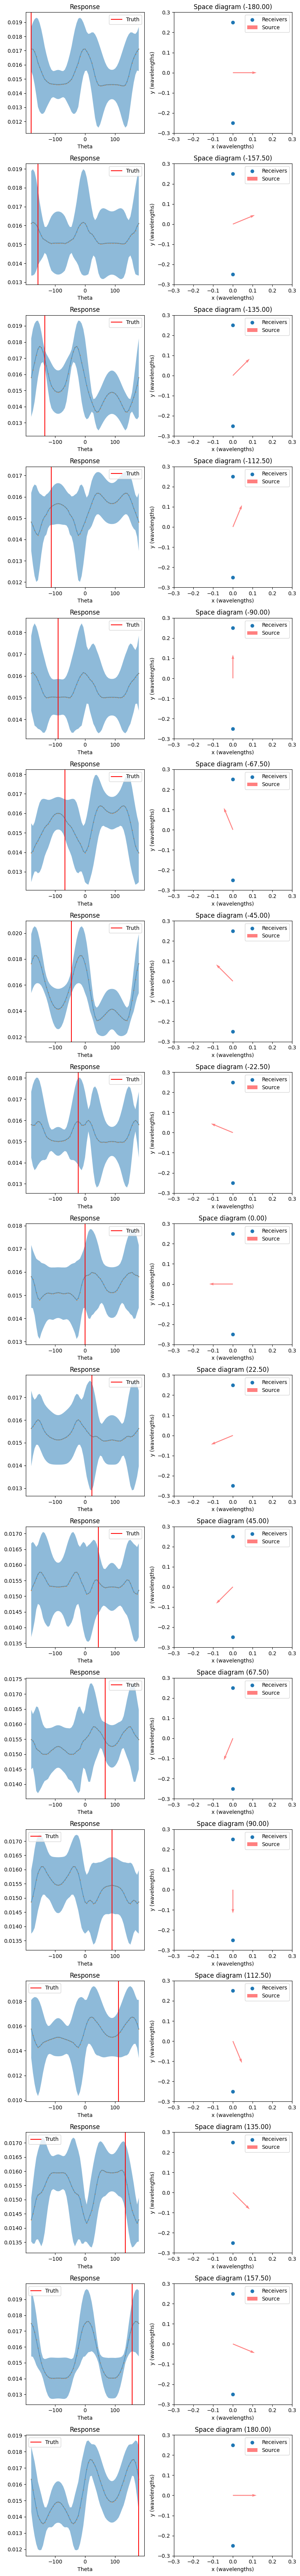

In [ ]:
carrier_frequency=2.4e9
signal_frequency=100e3 # 10khz signal 
wavelength=c/carrier_frequency
d=UCADetector(10e6,2,wavelength/4) # 1Mhz sampling

analyze_beamformer(d,carrier_frequency,signal_frequency,n_intervals=1+8*2, n_repeats=5, sigma=1,plot_raw_signal=False)